# **Classifying Clothing Images**

In [1]:
# Import the necessary libraries
import numpy as np
import torch
import matplotlib.pyplot as plt

In [3]:
!pip install GPUtil

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=b30b9705c7eecb7970c1c26f29687511b0dc59d5633b62e494343ca0c1a1c49f
  Stored in directory: /root/.cache/pip/wheels/2b/4d/8f/55fb4f7b9b591891e8d3f72977c4ec6c7763b39c19f0861595
Successfully built GPUtil


In [9]:
# GPU check
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 11.6 GB  | Proc size: 682.8 MB
GPU RAM Free: 15095MB | Used: 0MB | Util   0% | Total 15360MB


In [12]:
# Loading the Fashion-MNIST dataset
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                 transforms.Normalize(0.5, 0.5)
                               ])

# Download and load the training data
trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True)

In [13]:
# Examine a sample
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


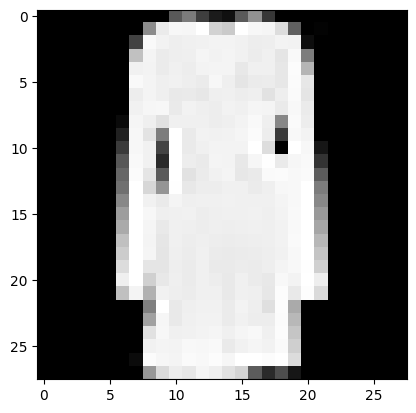

In [14]:
plt.imshow(images[1].numpy().squeeze(), cmap = 'Greys_r')

In [15]:
# Define the network architecture
from torch import nn, optim
import torch.nn.functional as F

model = nn.Sequential(nn.Linear(784, 256),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(256, 128),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim = 1)
                     )

# Define the loss
criterion = nn.NLLLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.002)

# Define the epochs
epochs = 30

train_losses, test_losses = [], []

for e in range(epochs):
  running_loss = 0
  for images, labels in trainloader:
    # Flatten Fashion-MNIST images into a 784 long vector
    images = images.view(images.shape[0], -1)

    # Training pass
    optimizer.zero_grad()

    output = model.forward(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
  else:
    test_loss = 0
    accuracy = 0

    # Turn off gradients for validation, saves memory and computation
    with torch.no_grad():
      # Set the model to evaluation mode
      model.eval()

      # Validation pass
      for images, labels in testloader:
        images = images.view(images.shape[0], -1)
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)

        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))

    model.train()
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))

    print("Epoch: {}/{}..".format(e+1, epochs),
          "Training loss: {:.3f}..".format(running_loss/len(trainloader)),
          "Test loss: {:.3f}..".format(test_loss/len(testloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30.. Training loss: 0.582.. Test loss: 0.453.. Test Accuracy: 0.831
Epoch: 2/30.. Training loss: 0.457.. Test loss: 0.405.. Test Accuracy: 0.851
Epoch: 3/30.. Training loss: 0.419.. Test loss: 0.439.. Test Accuracy: 0.844
Epoch: 4/30.. Training loss: 0.399.. Test loss: 0.393.. Test Accuracy: 0.859
Epoch: 5/30.. Training loss: 0.388.. Test loss: 0.402.. Test Accuracy: 0.856
Epoch: 6/30.. Training loss: 0.370.. Test loss: 0.369.. Test Accuracy: 0.867
Epoch: 7/30.. Training loss: 0.360.. Test loss: 0.364.. Test Accuracy: 0.870
Epoch: 8/30.. Training loss: 0.353.. Test loss: 0.370.. Test Accuracy: 0.870
Epoch: 9/30.. Training loss: 0.349.. Test loss: 0.358.. Test Accuracy: 0.872
Epoch: 10/30.. Training loss: 0.339.. Test loss: 0.365.. Test Accuracy: 0.871
Epoch: 11/30.. Training loss: 0.336.. Test loss: 0.361.. Test Accuracy: 0.869
Epoch: 12/30.. Training loss: 0.332.. Test loss: 0.461.. Test Accuracy: 0.856
Epoch: 13/30.. Training loss: 0.329.. Test loss: 0.376.. Test Accuracy: 0

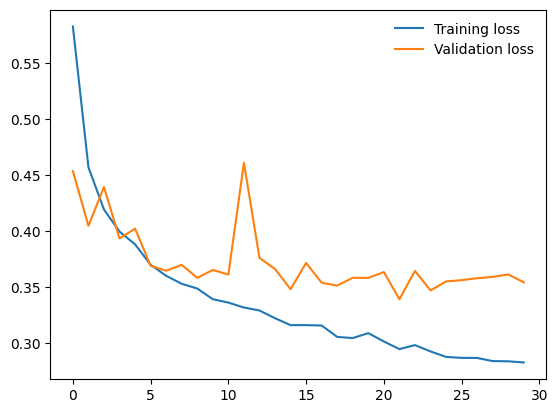

In [16]:
plt.plot(train_losses, label = "Training loss")
plt.plot(test_losses, label = "Validation loss")
plt.legend(frameon = False)

**Overfitting**

The training loss decreases with each epoch but the validation loss increases after some epochs. It is a clear case of overfitting. Solutions to tackle overfitting:

1. Early stopping - From the graph it's clear that on stopping at 10 epochs I can get a better validation as well as training loss.

2. Dropout - Randomly drop input units.

In [17]:
# Define view_classify function
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

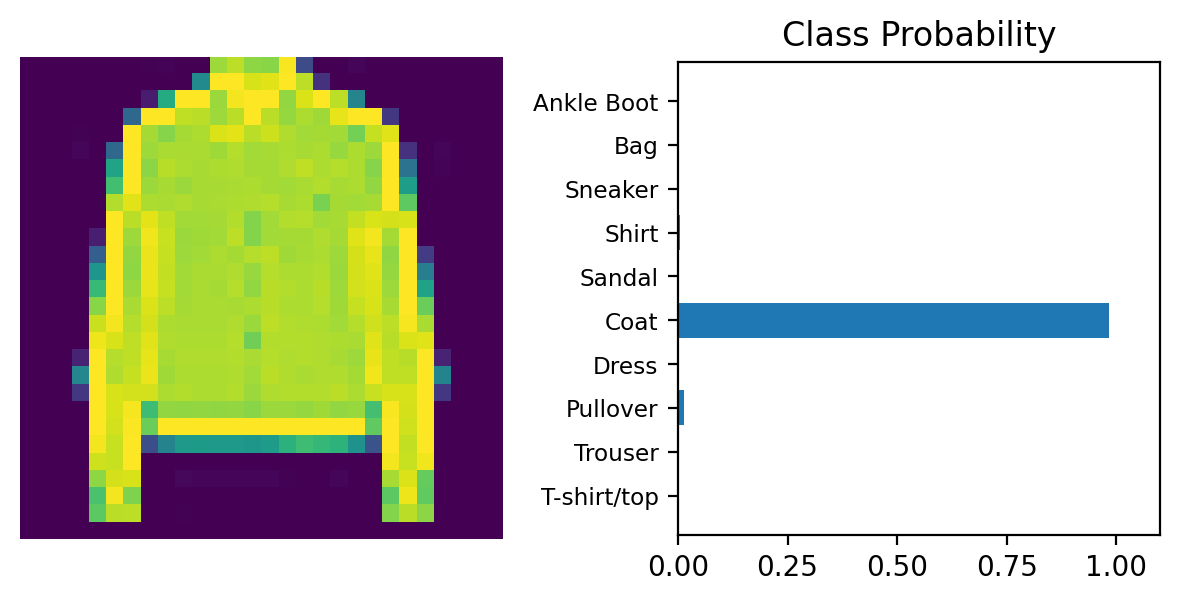

In [19]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Testing out the network
dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[0]

# Convert 2D image to 1D vector
img = img.resize_(1, 784)

# Calculate the class probabilites (log softmax) for img
ps = torch.exp(model(img))

# Plot the image and probabilites
view_classify(img, ps, version='Fashion')

**Saving the model**

In [20]:
print("My model: \n\n", model, "\n")
print("The state dict keys: \n\n", model.state_dict().keys())

My model: 

 Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.2, inplace=False)
  (9): Linear(in_features=64, out_features=10, bias=True)
  (10): LogSoftmax(dim=1)
) 

The state dict keys: 

 odict_keys(['0.weight', '0.bias', '3.weight', '3.bias', '6.weight', '6.bias', '9.weight', '9.bias'])


In [21]:
torch.save(model.state_dict(), 'checkpoint.pth')

**Load the saved model**

In [22]:
state_dict = torch.load("checkpoint.pth")
print(state_dict.keys())

odict_keys(['0.weight', '0.bias', '3.weight', '3.bias', '6.weight', '6.bias', '9.weight', '9.bias'])


In [23]:
# Load the state dict to the network
model.load_state_dict(state_dict)
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.2, inplace=False)
  (9): Linear(in_features=64, out_features=10, bias=True)
  (10): LogSoftmax(dim=1)
)
